# Load Image

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
from PIL import Image
%matplotlib inline
import os
import time
import cv2
import glob
import random

from keras.preprocessing import image

from keras.applications import vgg16 
from keras import models, layers, optimizers
from tensorflow.keras.optimizers import RMSprop

seed = 10
random.seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d choerulafifanto/apimembara
!mkdir fireforest

 99% 1.46G/1.47G [00:42<00:00, 52.8MB/s]
100% 1.47G/1.47G [00:42<00:00, 37.0MB/s]


In [ ]:
! unzip apimembara.zip -d fireforest

Streaming output truncated to the last 5000 lines.
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7758.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7759.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame776.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7760.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7761.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7762.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7763.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7764.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7765.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7766.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7767.jpg  
  inflating: fireforest/Tr

# Image Description

In [ ]:
train_fire_img = glob.glob('/content/fireforest/Training/Training/Fire/*.jpg')
train_nofire_img = glob.glob('/content/fireforest/Training/Training/No_Fire/*.jpg')

print("Total number of training fire images: ", len(train_fire_img))
print("Total number of training no fire images: ", len(train_nofire_img))

# make train_image_names as serie object
train_fire_img = pd.Series(train_fire_img)
train_nofire_img = pd.Series(train_nofire_img)

train_img = train_fire_img.append(train_nofire_img)
train_img = train_img.sample(frac=1).reset_index(drop=True) # shuffling

print("Total number of training images: ", len(train_img))

Total number of training fire images:  25018
Total number of training no fire images:  14357
Total number of training images:  39375


In [ ]:
test_fire_img = glob.glob('/content/fireforest/Test/Test/Fire/*.jpg')
test_nofire_img = glob.glob('/content/fireforest/Test/Test/No_Fire/*.jpg')

print("Total number of test fire images: ", len(test_fire_img))
print("Total number of test no fire images: ", len(test_nofire_img))

# make train_image_names as serie object
test_fire_img = pd.Series(test_fire_img)
test_nofire_img = pd.Series(test_nofire_img)

test_img = test_fire_img.append(test_nofire_img)
test_img = test_img.sample(frac=1).reset_index(drop=True) # shuffling

print("Total number of test images: ", len(test_img))

Total number of test fire images:  5137
Total number of test no fire images:  3480
Total number of test images:  8617


In [ ]:
masked_img = glob.glob('/content/fireforest/Masks/Masks/*.png')
print("Total number of masked images: ", len(masked_img))

masked_img = pd.Series(masked_img)

Total number of masked images:  2003


In [ ]:
# train_df: a dataframe with 2 field: filename, label

train_df = pd.DataFrame()

# generate Filename field
train_df['filename'] = train_img.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['label'] = train_img.map(lambda img_name: int(1) if img_name.split("/")[-2] == 'Fire' else int(0))

train_df.tail()

,filename,label
39370,resized_frame8773.jpg,1
39371,resized_frame15882.jpg,1
39372,lake_resized_lake_frame8180.jpg,0
39373,resized_frame3709.jpg,0
39374,resized_frame25357.jpg,1


In [ ]:
# test_df: a dataframe with 2 field: filename, label

test_df = pd.DataFrame()

# generate Filename field
test_df['filename'] = test_img.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
test_df['label'] = test_img.map(lambda img_name: int(1) if img_name.split("/")[-2] == 'Fire' else int(0))

test_df.tail()

,filename,label
8612,resized_test_fire_frame4280.jpg,1
8613,resized_test_nofire_frame2542.jpg,0
8614,resized_test_fire_frame1892.jpg,1
8615,resized_test_fire_frame2257.jpg,1
8616,resized_test_nofire_frame264.jpg,0


In [ ]:
class_id_distribution = train_df['label'].value_counts()
print(class_id_distribution)

1    25018
0    14357
Name: label, dtype: int64


# Modeling

In [ ]:
train_dir = '/content/fireforest/Training/Training'
test_dir = '/content/fireforest/Test/Test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.3)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (254, 254),
                                                    subset='training')  

val_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (254, 254),
                                                  subset='validation') 


Found 27563 images belonging to 2 classes.
Found 11812 images belonging to 2 classes.


In [ ]:
#https://www.kaggle.com/code/brsdincer/forest-fire-detection-prediction-all-process#CNN
Model = Sequential()

Model.add(Conv2D(32,(3,3),activation="relu",
                 input_shape=(254,254,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

#
Model.add(Conv2D(64,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.2))
Model.add(MaxPooling2D((2,2)))

#
Model.add(Conv2D(128,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.5))
Model.add(MaxPooling2D((2,2)))


#
Model.add(Flatten())
Model.add(Dense(256,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(1,activation="sigmoid"))

In [ ]:
Model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
%%time
# Train the model.
history = Model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 62s - loss: 4.2843 - accuracy: 0.8365 - val_loss: 0.6088 - val_accuracy: 0.9910 - 62s/epoch - 622ms/step
Epoch 2/20
100/100 - 44s - loss: 0.4524 - accuracy: 0.8810 - val_loss: 0.4238 - val_accuracy: 0.9710 - 44s/epoch - 436ms/step
Epoch 3/20
100/100 - 44s - loss: 0.3701 - accuracy: 0.8940 - val_loss: 0.5928 - val_accuracy: 0.9300 - 44s/epoch - 443ms/step
Epoch 4/20
100/100 - 50s - loss: 0.3443 - accuracy: 0.9020 - val_loss: 1.1311 - val_accuracy: 0.6330 - 50s/epoch - 499ms/step
Epoch 5/20
100/100 - 50s - loss: 0.3406 - accuracy: 0.9135 - val_loss: 0.5716 - val_accuracy: 0.7020 - 50s/epoch - 499ms/step
Epoch 6/20
100/100 - 51s - loss: 0.4506 - accuracy: 0.9030 - val_loss: 0.4808 - val_accuracy: 0.8950 - 51s/epoch - 513ms/step
Epoch 7/20
100/100 - 44s - loss: 0.3062 - accuracy: 0.9180 - val_loss: 0.1656 - val_accuracy: 0.9550 - 44s/epoch - 445ms/step
Epoch 8/20
100/100 - 43s - loss: 0.3998 - accuracy: 0.9070 - val_loss: 0.4825 - val_accuracy: 0.6840 - 43s/epoch - 431

In [ ]:
import pickle
with open('FF', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
Model.save("FF.h5")

In [ ]:
history = pickle.load(open('FF', "rb"))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

AttributeError: ignored

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

AttributeError: ignored

# Testing

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size = (254, 254)) 

Found 8617 images belonging to 2 classes.


In [ ]:
pred = Model.predict(train_generator)
np.around(pred)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8617 entries, 0 to 8616
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8617 non-null   object
 1   label     8617 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 134.8+ KB


In [ ]:
test_df['pred'] = np.around(pred)
test_df

,filename,label,pred
0,resized_test_fire_frame551.jpg,1,0.0
1,resized_test_fire_frame1896.jpg,1,0.0
2,resized_test_nofire_frame3119.jpg,0,0.0
3,resized_test_fire_frame1171.jpg,1,1.0
4,resized_test_fire_frame2182.jpg,1,0.0
...,...,...,...
8612,resized_test_fire_frame4280.jpg,1,1.0
8613,resized_test_nofire_frame2542.jpg,0,0.0
8614,resized_test_fire_frame1892.jpg,1,0.0
8615,resized_test_fire_frame2257.jpg,1,1.0


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df['label'], test_df['pred'], target_names=['No_Fire','Fire']))

              precision    recall  f1-score   support

     No_Fire       0.40      0.78      0.53      3480
        Fire       0.58      0.21      0.30      5137

    accuracy                           0.44      8617
   macro avg       0.49      0.49      0.41      8617
weighted avg       0.50      0.44      0.39      8617



In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(test_df['label'], test_df['pred'])
import seaborn as sns

cf_matrix

array([[2702,  778],
       [4080, 1057]])

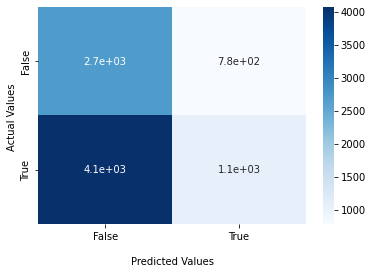

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()